Candidate rate indicators (median Value):
                                    Name  median_value
1   Unplanned hospital readmission rates         25.50
0  Infant and young child mortality rate         89.75

Chosen indicator: Infant and young child mortality rate


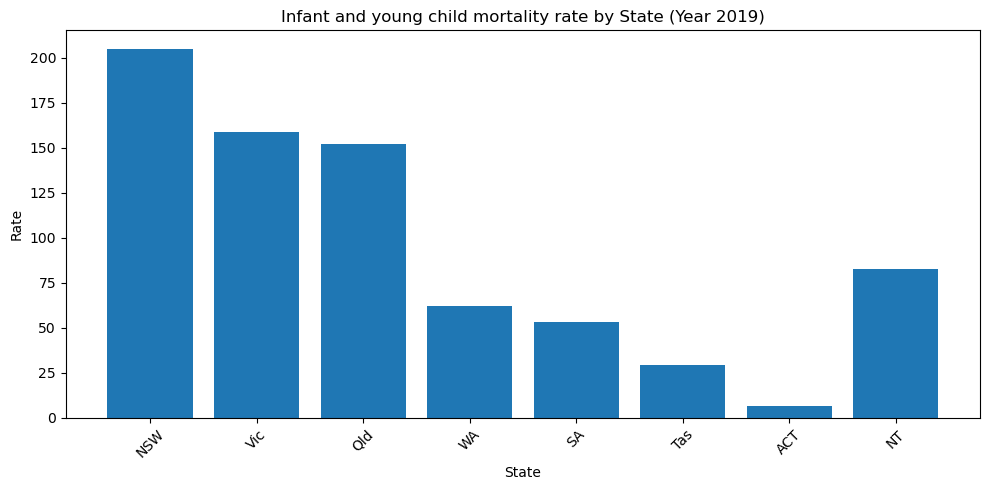

Saved: outputs\figures\Infant_and_young_child_mortality_rate_bar_2019.png


C:\Users\ANJANA MANOJ\AppData\Local\Temp\ipykernel_51516\728359039.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for st, g in sel_agg.sort_values(["State","Year"]).groupby("State"):


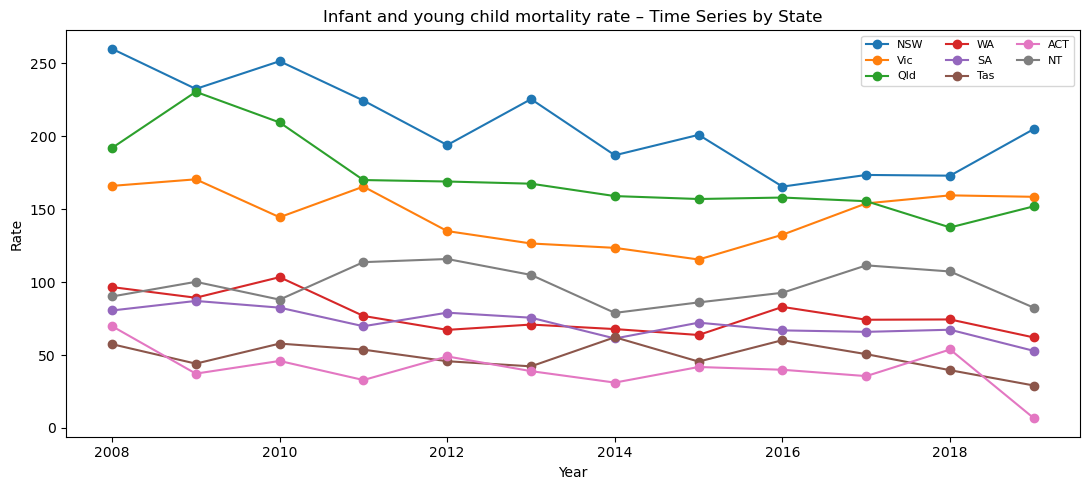

Saved: outputs\figures\Infant_and_young_child_mortality_rate_timeseries.png


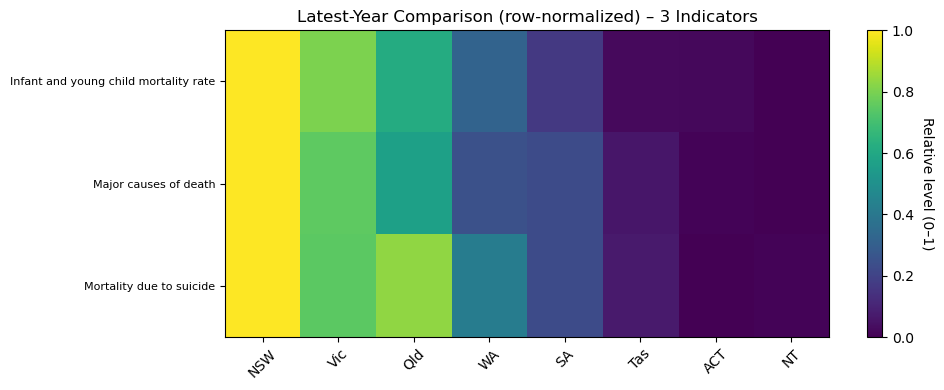

Saved: outputs\figures\ahpf_outcomes_heatmap_latest_year_normalized.png


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---------- files (must exist in the same folder as the notebook) ----------
AHPF_CLEAN = Path("ahpf_outcomes_clean.csv")
PIVOT_FILE = Path("ahpf_outcomes_pivot_2019.csv")   # change if yours is a different year
OUT = Path("outputs/figures"); OUT.mkdir(parents=True, exist_ok=True)

STATE_ORDER = ["NSW","Vic","Qld","WA","SA","Tas","ACT","NT","Australia"]

# ---------- load ----------
ahpf = pd.read_csv(AHPF_CLEAN, low_memory=False)
# coerce types
ahpf["Year"] = pd.to_numeric(ahpf.get("Year"), errors="coerce").astype("Int64")
ahpf["Value"] = (
    ahpf["Value"].astype(str)
        .str.replace(",", "", regex=False)
        .str.replace("\u2212","-", regex=False)          # unicode minus
        .str.extract(r"([-+]?\d*\.?\d+(e[-+]?\d+)?)", expand=False)[0]
        .astype(float)
)

# ---------- find rate-like indicators (strict) ----------
name = ahpf["Name"].astype(str)
rate_like = (
    name.str.contains("rate", case=False, na=False)
    & ~name.str.contains("number|count|volume|cases", case=False, na=False)
)

cands = (
    ahpf[rate_like]
    .groupby("Name", as_index=False)["Value"]
    .median()
    .rename(columns={"Value":"median_value"})
)

# keep only plausible rates (change bounds if you need another indicator type)
cands = cands[(cands["median_value"] > 0) & (cands["median_value"] < 200)].sort_values("median_value")
print("Candidate rate indicators (median Value):")
print(cands.tail(20))   # show last 20 by median to pick from

# ---------- pick one ----------
# Option 1: set it manually after inspecting the printed list:
# CHOSEN = "Infant and young child mortality rate"
# Option 2: auto-pick the one with the most rows in the plausible set:
if "CHOSEN" not in globals():
    valid_names = ahpf["Name"].astype(str).isin(cands["Name"])
    CHOSEN = (
        ahpf[valid_names]
        .groupby("Name")["Value"]
        .size()
        .sort_values(ascending=False)
        .index[0]
    )

print("\nChosen indicator:", CHOSEN)

sel = ahpf[ahpf["Name"].astype(str) == CHOSEN].copy()
# keep only proper states and drop obvious non-state geographies if present
sel = sel[sel["State"].isin(STATE_ORDER)]

# de-duplicate: there can be multiple disaggregations; use median per State-Year
sel_agg = (
    sel.dropna(subset=["State","Year","Value"])
       .groupby(["State","Year"], as_index=False)["Value"].median()
)
sel_agg["State"] = pd.Categorical(sel_agg["State"], categories=STATE_ORDER, ordered=True)

# heuristic sanity check: if values still look absurd, warn
q95 = sel_agg["Value"].quantile(0.95)
if q95 > 500:
    print("\nWARNING: Values still look very large for a rate. "
          "You may have selected a non-rate indicator or a mis-scaled series.")
    print("Try choosing a different `CHOSEN` string from the printed candidate list.")

# pick label
y_label = "Rate" if "rate" in CHOSEN.lower() else "Value"

# ---------- A) Bar: latest year ----------
if sel_agg["Year"].notna().any():
    latest = int(sel_agg["Year"].dropna().max())
    b = sel_agg[sel_agg["Year"] == latest].sort_values("State")
    plt.figure(figsize=(10,5))
    plt.bar(b["State"].astype(str), b["Value"])
    plt.title(f"{CHOSEN} by State (Year {latest})")
    plt.ylabel(y_label)
    plt.xlabel("State")
    plt.xticks(rotation=45)
    plt.tight_layout()
    outp = OUT / f"{CHOSEN[:60].replace(' ','_')}_bar_{latest}.png"
    plt.savefig(outp, dpi=200); plt.show()
    print("Saved:", outp)

# ---------- B) Time series per state ----------
plt.figure(figsize=(11,5))
for st, g in sel_agg.sort_values(["State","Year"]).groupby("State"):
    if g.empty: 
        continue
    plt.plot(g["Year"].astype(int), g["Value"], marker="o", label=str(st))
plt.title(f"{CHOSEN} – Time Series by State")
plt.ylabel(y_label)
plt.xlabel("Year")
plt.legend(loc="best", ncol=3, fontsize=8)
plt.tight_layout()
outp = OUT / f"{CHOSEN[:60].replace(' ','_')}_timeseries.png"
plt.savefig(outp, dpi=200); plt.show()
print("Saved:", outp)

# ---------- C) Heatmap: normalize per indicator so rows are comparable ----------
if PIVOT_FILE.exists():
    pv = pd.read_csv(PIVOT_FILE)
    first_col = pv.columns[0]
    pv = pv.rename(columns={first_col: "indicator"}).set_index("indicator")
    keep = [c for c in STATE_ORDER if c in pv.columns]
    heat = pv[keep].apply(pd.to_numeric, errors="coerce")

    # row-normalize to 0..1 so each indicator is visible even if scales differ
    norm = (heat - heat.min(axis=1).values.reshape(-1,1)) / (heat.max(axis=1)-heat.min(axis=1)).replace(0,np.nan).values.reshape(-1,1)

    plt.figure(figsize=(10, max(4, 0.35*len(norm))))
    plt.imshow(norm.values, aspect="auto", cmap="viridis")
    plt.title(f"Latest-Year Comparison (row-normalized) – {len(norm)} Indicators")
    plt.yticks(ticks=np.arange(len(norm.index)), labels=norm.index, fontsize=8)
    plt.xticks(ticks=np.arange(len(keep)), labels=keep, rotation=45)
    cbar = plt.colorbar()
    cbar.ax.set_ylabel("Relative level (0–1)", rotation=270, labelpad=15)
    plt.tight_layout()
    outp = OUT / "ahpf_outcomes_heatmap_latest_year_normalized.png"
    plt.savefig(outp, dpi=200); plt.show()
    print("Saved:", outp)
else:
    print(f"Pivot file not found: {PIVOT_FILE} (skipping heatmap)")
